In [1]:
import pnl
import scraper
from db_initialize import conn
from datetime import date

dropping tables
Loading Hours tables


## 1. Scrape the Auction Result

In [2]:
auction_result = scraper.get_ftr_auction_result()

Creating a Session.
Requesting the url.
Processing the page.
CSV download list created.
Start Combining CSVs.
(4636, 16) monthly 202204
(4636, 17)
(3353, 16) long_term_2 2022
(40236, 17)
(3326, 16) long_term_1 2022
(39912, 17)
(5576, 16) monthly 202203
(5576, 17)
(5690, 16) monthly 202202
(5690, 17)
(7834, 16) monthly 202201
(7834, 17)


## 2. Generate the price History

In [3]:
input_date = date(2022,3,1)
daily_da_lmp = pnl.f_get_monthly_settlement_price(input_date)

Scraping Data...
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220301.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220302.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220303.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220304.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220305.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220306.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220307.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220308.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220309.csv
(28944, 10)
https://www.iso-ne.com/static-transform/csv/histRpts/da-lmp/WW_DALMP_ISO_20220310.csv
(28992, 10)
htt

## 3. Insert the data into the database

In [4]:
daily_da_lmp.to_sql('IsoneDailyDaLmp',con = conn, index = False, if_exists = 'append')
auction_result.to_sql('FtrAuctionResult',con = conn, index = False, if_exists = 'append')

C:\Users\steve\anaconda3\lib\site-packages\pandas\core\generic.py:2663: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


## 4. Calculate the PnL for Mar22 settlement

In [5]:
mar_pnl = pnl.f_calculate_monthly_ftr_settlement_pnl('2022-03-01',conn)
print(mar_pnl.shape)

(290888, 23)


In [6]:
#aggregate
mar_pnl_by_company = mar_pnl[['Customer Name','Pnl']].groupby('Customer Name').sum().reset_index()

## 5. Calculate the PnL for Apr22 auction

In [7]:
apr_pnl = pnl.f_calculate_monthly_ftr_mta_pnl('monthly_202204',conn)
print(apr_pnl.shape)

(9612, 20)


In [8]:
#aggregate
apr_pnl_by_company = apr_pnl[['Customer Name','Pnl']].groupby('Customer Name').sum().reset_index()

## 6. Quick Visualization

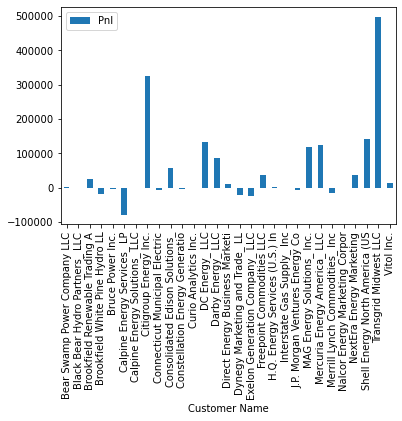

In [9]:
mar_pnl_by_company.plot.bar(x = 'Customer Name',y = 'Pnl')

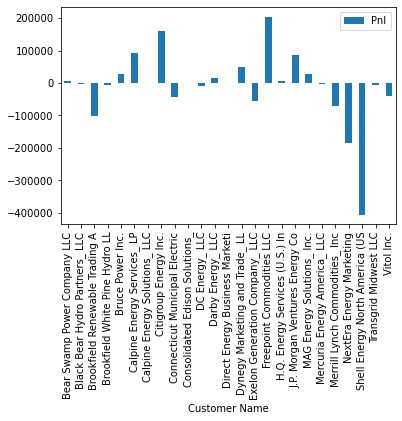

In [10]:
apr_pnl_by_company.plot.bar(x = 'Customer Name',y = 'Pnl')

In [33]:
    query = '''
        select 
            a.*,
            b.date,
            b."Congestion Component" as Congestion_Source,
            c."Congestion Component" as Congestion_Sink,
            c."Congestion Component" - b."Congestion Component"  as End_Price,
            d."Hours" as "Hours",
            coalesce(d."Hours" *
            (
                (c."Congestion Component" - b."Congestion Component") - 
                (a."Award FTR Price" / (case when a.FileName like 'long_term%%' then e.HoursYear else e.Hours end))
            ) * 
            a."Award FTR MW" *
            (
                case when a."Buy/Sell" = 'BUY' then 1 else -1 end
            ),0) as Pnl
        from 
            FtrAuctionResult a
        left join
            DailyHours d
        on
            d.ClassType = a.ClassType and d.Month = a.Month
        left join
            MonthlyHours e
        on
            e.Month = d.Month and e.ClassType = a.ClassType 
        left join
            IsoneDailyDaLmp b
        on
            a."Source Location ID" = b."Location ID" and a."ClassType" = b."ClassType" and b.Date = d.Date
        left join
            IsoneDailyDaLmp c
        on
            a."Sink Location ID" = c."Location ID" and a."ClassType" = c."ClassType" and c.Date = b.Date
        where 
            a."Month" = '%s'
        ''' % '2022-03-01'

In [34]:
import pandas as pd

In [35]:
data = pd.read_sql(query,conn)

In [36]:
data.shape

(292050, 23)

In [37]:
data[data['Pnl'].isnull()]

,Auction Name,Customer ID,Customer Name,Source Location ID,Source Location Name,Source Location Type,Sink Location ID,Sink Location Name,Sink Location Type,Buy/Sell,...,FileName,TimeStamp,UpdateTime,Month,Date,Congestion_Source,Congestion_Sink,End_Price,Hours,Pnl


In [26]:
query2 = '''select * from IsoneDailyDaLmp where "location id" = 407'''

In [27]:
data2 = pd.read_sql(query2,conn)

In [38]:
data2 = data[['Customer Name','Pnl']].groupby('Customer Name').sum().reset_index()

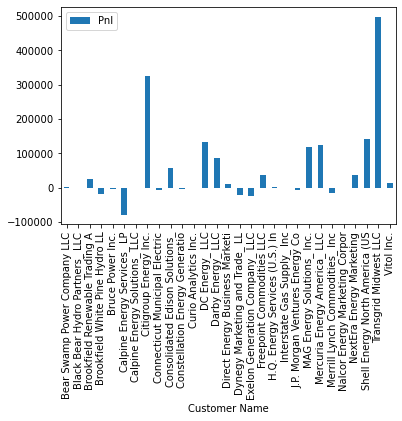

In [39]:
data2.plot.bar(x = 'Customer Name',y = 'Pnl')